# **Data and Analysis NOAA Climate Predictions**
## Graph Generation Notebook For Write-Up File
Data Link:
https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/statewide/time-series

## Project Goal:

The project plans to compile data from the NOAA website for each state's climate data, more specifically, yearly temperature and precipitation data from 1900 to 2023. The project will then analyze this data in order to:
 - Identify which locations have experienced the most and least change in weather
 - Predict which states are likely to have the most severe outcomes from a changing climate
 - Utilize this data to show which locations will likely see out and in-migrations of people along with where climate change mitigation and increased population infrastructure should be invested in


## Pipeline Overview:

The pipeline utilizes a link off the NOAA website that fetches CSV tables based on the link inputs or table inputs on the webpage. It was originally difficult to scrape the data because the webpage generates the table with JavaScript, and there is no easy way to scrape each row from the HTML. However, on the page, there is a place where you can download the data from a CSV. This button is linked to a semi-unique link based on your inputs where each table is generated and stored. We were able to exploit this feature in order to get tables for the states.

Pipeline decisions/nuances:
- Chose not to include Alaska in general data because it is not compatible with the geopandas or plotly United States map libraries.
- General data set to 12-month periods from January of start year to January of the next year for consistent average temperatures and consistent cumulative rainfall measurement year over year.
- Built a function that enables a user to grab specified data from multiple aggregated datasets based on certain parameters.

###Functions:
For the Climate Data API:
- get_url()
  - constructs a URL for downloading climate data for a specified state and time range
- get_state_weather_data()
  - retrieves and compiles climate data for a given state across specified data types into a clean dataframe

### 1. Functions to Grab and Compiling Data
A multi use function that can be used to grab any data that may be necessary for the project.

In [ ]:
import pandas as pd

locations_raw = {"1":"Alabama","50":"Alaska","2":"Arizona","3":"Arkansas","4":"California","5":"Colorado","6":"Connecticut","7":"Delaware","8":"Florida","9":"Georgia","51":"Hawaii","10":"Idaho","11":"Illinois","12":"Indiana","13":"Iowa","14":"Kansas","15":"Kentucky","16":"Louisiana","17":"Maine","18":"Maryland","19":"Massachusetts","20":"Michigan","21":"Minnesota","22":"Mississippi","23":"Missouri","24":"Montana","25":"Nebraska","26":"Nevada","27":"New Hampshire","28":"New Jersey","29":"New Mexico","30":"New York","31":"North Carolina","32":"North Dakota","33":"Ohio","34":"Oklahoma","35":"Oregon","36":"Pennsylvania","66":"Puerto Rico","37":"Rhode Island","38":"South Carolina","39":"South Dakota","40":"Tennessee","41":"Texas","42":"Utah","43":"Vermont","44":"Virginia","45":"Washington","49":"Washington, D.C.","46":"West Virginia","47":"Wisconsin","48":"Wyoming"}
locations_dict = {v: k for k, v in locations_raw.items()}

valid_datatypes = {"tavg": "Average Temperature","tmax": "Maximum Temperature","tmin": "Minimum Temperature","pcp": "Total Precipitation","cdd": "cdd", "hdd":"hdd","pdsi":"pdsi","zndx":"zndx"}

def get_url(state, month, data_type="tavg", start_year=1895, end_year=2023, time_scale=12):
  """Constructs a URL for downloading climate data for a specified state and time range.

  Args:
  - state (str): The state for which the data is to be retrieved.
  - month (int): The month (1-12) for which the data is to be retrieved.
  - data_type (str, optional): The type of climate data to retrieve. Defaults to "tavg" (average temperature).
  - start_year (int, optional): The starting year for the data retrieval. Defaults to 1895.
  - end_year (int, optional): The ending year for the data retrieval. Defaults to 2023.
  - time_scale (int, optional): The time scale for data aggregation. Defaults to 1 (monthly).

  Returns:
  - url: A URL string that can be used to retrieve the specified climate data.
  """

  # Assert Parameters
  assert state in locations_dict.keys()
  assert data_type in valid_datatypes.keys()
  assert month >= 1 and month <= 12
  assert start_year >= 1895 and start_year <= 2023
  assert end_year > start_year and end_year >= 1895 and end_year <= 2023

  state_num = int(locations_dict.get(state, "1"))

  # Build URL
  url = f'https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/statewide/time-series/{state_num}/{data_type}/{time_scale}/{month}/{start_year}-{end_year}.csv?base_prd=true&begbaseyear={str(start_year+1)}&endbaseyear={str(start_year+1)}/'

  return url

def get_state_weather_data(state, data_types=["tavg", "pcp"], months=range(1,2)):
  """Retrieves and compiles climate data for a given state across specified data types.

  Args:
  - state (str): The state for which the weather data is to be retrieved.
  - data_types (list of str, optional): A list of data types to retrieve. Defaults to ["tavg", "pcp"] which are
    average temperature and total precipitation respectively.
  - months (range, optional): A range for months to retrieve data for. Defaults to range(1,2) which would mean from January (inclusive) to February (exclusive).

  Returns:
  - data: A DataFrame containing the combined weather data for the given state and data types.

  """
  total_data = {}

  for data_type in data_types:
    total_data[data_type] = pd.DataFrame()
    for month in months:
      url = get_url(state, month, data_type=data_type)
      data = pd.read_csv(url, sep = ',', skiprows=4)
      data = pd.DataFrame(data)
      data['Year'] = data['Date'].map(lambda x: str(x)[:-2]) # Grabs year from Date int
      data['Month'] = data['Date'].map(lambda x: str(x)[-2:]) # Grabs month from Date int
      data = data.drop(['Anomaly', 'Date'], axis=1)
      data['State'] = state
      data = data.rename(columns={'Value': valid_datatypes[data_type]}) # Changes value to more readable format
      data = data.iloc[:, [3,0,1,2]]
      total_data[data_type] = pd.concat([total_data[data_type], data])

  total_data_keys = list(total_data.keys())
  final_data = total_data[list(total_data_keys)[0]].copy()

  for key in total_data_keys[1:]:
    final_data = pd.concat([final_data, pd.DataFrame(total_data[key][valid_datatypes[key]])], axis = 1)


  return final_data

## 2. Scraping the Data
Using the function built above to grab all the general data needed for the project and put it into one file.

In [ ]:
# Grabs data on yearly temperature averages by state
import pandas as pd

compiled_data = pd.DataFrame()

# All States
us_states = [
    'Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado',
    'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Idaho',
    'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
    'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
    'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
    'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
    'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
    'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
    'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
    'West Virginia', 'Wisconsin', 'Wyoming']

# Retrieving average temperature and total precipitation data for all states from 1895-2023 for the month of January
for state in us_states:
  weather_data = get_state_weather_data(state, ['tavg', 'pcp'], range(1,2))
  compiled_data = pd.concat([compiled_data, weather_data])


compiled_data = compiled_data.drop('Month', axis=1)
compiled_data = compiled_data.reset_index(drop=True)
compiled_data

,State,Average Temperature,Year,Total Precipitation
0,Alabama,61.7,1896,47.21
1,Alabama,64.1,1897,45.56
2,Alabama,64.8,1898,48.55
3,Alabama,62.6,1899,51.10
4,Alabama,63.1,1900,45.58
...,...,...,...,...
6139,Wyoming,42.2,2019,16.12
6140,Wyoming,40.4,2020,18.46
6141,Wyoming,42.7,2021,11.38
6142,Wyoming,43.6,2022,14.47


In [ ]:
# Saving Data
compiled_data.to_csv('state_data_january.csv', index=False)

## 3. Visualizations:

A few graphs showing the range of data and potential project considerations, such as examining how temperature variations and averages have changed over time and what regions have become drier or warmer. Data interpretations are discussed more thoroughly in the project write up.

In [ ]:


# Scatter plot of total precipitation and year for all states
px.scatter(compiled_data, x='Year', y='Total Precipitation', color='State', title = 'Total Precipitation Compared to Year for Different States')

In [ ]:
# Scatter plot of average Temperature and year for all states with trendlines for each state
px.scatter(compiled_data, x='Year', y='Average Temperature', color='State', title = 'Average Temperature Compared to Year for Different States', trendline="ols")

### Analysis:

All linear lines of best fit have a positive slope, meaning that temperatures have become warmer. This will be useful to consider on a state-by-state basis.

In [ ]:
# Building grouped dataframe for the map
df_map = compiled_data
df_map.groupby(['State']).agg({'Average Temperature': 'mean', 'Total Precipitation': 'mean'})
df_map = df_map.rename(columns={'Average Temperature': 'Average of Temperature (°F)', 'Total Precipitation': 'Average Precipitation (inches)'})

# Maps state to code for state map
code = {'Alabama': 'AL',
        'Alaska': 'AK',
        'Arizona': 'AZ',
        'Arkansas': 'AR',
        'California': 'CA',
        'Colorado': 'CO',
        'Connecticut': 'CT',
        'Delaware': 'DE',
        'District of Columbia': 'DC',
        'Florida': 'FL',
        'Georgia': 'GA',
        'Hawaii': 'HI',
        'Idaho': 'ID',
        'Illinois': 'IL',
        'Indiana': 'IN',
        'Iowa': 'IA',
        'Kansas': 'KS',
        'Kentucky': 'KY',
        'Louisiana': 'LA',
        'Maine': 'ME',
        'Maryland': 'MD',
        'Massachusetts': 'MA',
        'Michigan': 'MI',
        'Minnesota': 'MN',
        'Mississippi': 'MS',
        'Missouri': 'MO',
        'Montana': 'MT',
        'Nebraska': 'NE',
        'Nevada': 'NV',
        'New Hampshire': 'NH',
        'New Jersey': 'NJ',
        'New Mexico': 'NM',
        'New York': 'NY',
        'North Carolina': 'NC',
        'North Dakota': 'ND',
        'Ohio': 'OH',
        'Oklahoma': 'OK',
        'Oregon': 'OR',
        'Pennsylvania': 'PA',
        'Rhode Island': 'RI',
        'South Carolina': 'SC',
        'South Dakota': 'SD',
        'Tennessee': 'TN',
        'Texas': 'TX',
        'Utah': 'UT',
        'Vermont': 'VT',
        'Virginia': 'VA',
        'Washington': 'WA',
        'West Virginia': 'WV',
        'Wisconsin': 'WI',
        'Wyoming': 'WY'}

# Mapping the code to each state
df_map['Code'] = df_map['State'].map(code)

df_1896 = df_map.loc[df_map['Year'] == '1896']
df_2023 = df_map.loc[df_map['Year'] == '2023']

In [ ]:
# Plotting the figure
fig = px.choropleth(df_1896,
                    locations='Code',
                    color='Average of Temperature (°F)',
                    color_continuous_scale='spectral_r',
                    hover_name='State',
                    locationmode='USA-states',
                    labels={'State Compared to Temperature Variance (°F)'},
                    scope='usa')
fig.update_layout(title='Average Temperatures 1896')
fig.add_scattergeo(
    locations=df_1896['Code'],
    locationmode="USA-states",
    text = df_1896['Average of Temperature (°F)'],
    featureidkey="properties.NAME_3",
    mode = 'text',
    textfont=dict(
            family="helvetica",
            size=12,
            color="black"
    ))
fig.show() # Shows the plot



In [ ]:
# Plotting the figure
fig = px.choropleth(df_2023,
                    locations='Code',
                    labels = 'Average of Temperature (°F)',
                    color ='Average of Temperature (°F)',
                    color_continuous_scale='spectral_r',
                    hover_name='State',
                    locationmode='USA-states',
                    scope='usa')
fig.update_layout(title='Average Temperature 2023')
fig.add_scattergeo(
    locations=df_2023['Code'],
    locationmode="USA-states",
    text = df_2023['Average of Temperature (°F)'],
    featureidkey="properties.NAME_3",
    mode = 'text',
    textfont=dict(
            family="helvetica",
            size=12,
            color="black"
    ))
fig.show() # Shows the plot



In [ ]:
# Plotting the figure
fig = px.choropleth(df_map,
                    locations='Code',
                    color='Average of Temperature (°F)',
                    color_continuous_scale='spectral_r',
                    hover_name='State',
                    locationmode='USA-states',
                    labels={'State Compared to Temperature Variance (°F)'},
                    scope='usa')
fig.update_layout(title='Average Temperature (1896-2023)')
fig.show() # Shows the plot

## 4. Analysis/ML Plan:

After collecting and plotting a few subsets of the data, some factors that might be interesting to predict are future precipitation totals for each state, future temperature averages for each state, along with these values for the contiguous United States as a whole using regression plots. It made sense to then leverage these ideas to create a function that utilizes trends for different locations to predict precipitation and temperature values of any location based on trends of these factors for locations with similar latitudes and longitudes or averages, which would be a useful application of supervised machine learning. This could also be used to identify locations that are most likely to face the most climate-related difficulties and possibly provide a solid guess as to where people should move in order to best avoid the implications of a changing climate. It may also make sense to generate an interactive component to the work, such as a plotly dashboard, so users can examine specific data more precisely and interact with more precise maps and diagrams.

In [ ]:
# Plotting the figure
fig = px.choropleth(df_map,
                    locations='Code',
                    color='Average Precipitation (inches)',
                    color_continuous_scale='spectral_r',
                    hover_name='State',
                    locationmode='USA-states',
                    labels={'State Compared to Temperature Variance'},
                    scope='usa')
fig.show() # Shows the plot

In [ ]:
# Graph the average
import statsmodels.api as sm
variation_states = compiled_data.loc[compiled_data['State'].isin(['Texas', 'North Dakota', 'Florida', 'Minnesota'])]
variation_all = compiled_data.groupby(['Year']).agg({'Average Temperature': 'mean', 'Total Precipitation': 'var'})
variation_all['State'] = 'All States'
variation_all.reset_index(inplace= True)
variation_states = pd.concat([variation_states, variation_all], axis=0)
variation_states.reset_index(inplace= True)
fig = px.scatter(variation_states , x='Year', y='Average Temperature', color='State', title = 'Average Temperature Compared to Year for Different States', trendline="ols")


# Calculating OLS regression equations for each state
states = variation_states['State'].unique()
equations = {}

for state in states:
    state_data = variation_states[variation_states['State'] == state]
    X = sm.add_constant(state_data['Year'].astype('int'))
    y = state_data['Average Temperature']
    model = sm.OLS(y, X).fit()
    intercept, coef = model.params
    equation = f"y = {coef:.3f}x + {intercept:.3f}"
    equations[state] = equation

# Adding equations to the figure's layout
fig.update_layout(
    annotations=[
        dict(
            x=-0.05,
            y=-0.23,
            showarrow=False,
            text=", ".join([f"{state}: {equation}" for state, equation in equations.items()]),
            xref="paper",
            yref="paper"
        )
    ]
)


In [ ]:
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import numpy as np



def format_coefs(coefs):
    equation_list = [f"{coef}x^{i}" for i, coef in enumerate(coefs)]
    equation = "$" +  " + ".join(equation_list) + "$"

    replace_map = {"x^0": "", "x^1": "x", '+ -': '- '}
    for old, new in replace_map.items():
        equation = equation.replace(old, new)

    return equation

variation_all['Year'] = variation_all['Year'].astype(int)
X = variation_all.Year.values.reshape(-1, 1)
x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)

fig = px.scatter(variation_all, x='Year', y='Average Temperature', opacity=0.65)
for degree in [1, 2, 3, 4]:
    poly = PolynomialFeatures(degree)
    poly.fit(X)
    X_poly = poly.transform(X)
    x_range_poly = poly.transform(x_range)

    model = LinearRegression(fit_intercept=False)
    model.fit(X_poly, variation_all['Average Temperature'])
    y_poly = model.predict(x_range_poly)

    equation = format_coefs(model.coef_.round(2))
    fig.add_traces(go.Scatter(x=x_range.squeeze(), y=y_poly, name=equation))

fig.show()

In [ ]:
# Finding and plottling coefficients for all states
state_temp = df_map
coef_list = []

for state in state_temp['State'].tolist():
    state_data = state_temp[state_temp['State'] == state]
    X = sm.add_constant(state_data['Year'].astype('int'))
    y = state_data['Average of Temperature (°F)']
    model = sm.OLS(y, X).fit()
    intercept, coef = model.params
    coef_list.append(round(coef,3))

state_temp['Temperature Change Rate'] = np.array(coef_list)


# Plotting the figure
fig = px.choropleth(state_temp ,
                    locations='Code',
                    labels = 'Temperature Change Rate',
                    color ='Temperature Change Rate',
                    color_continuous_scale='spectral_r',
                    hover_name='State',
                    locationmode='USA-states',
                    scope='usa')
fig.update_layout(title='Average Change Rate of Temperature Annually (1896-2023)')
fig.add_scattergeo(
    locations=state_temp['Code'],
    locationmode="USA-states",
    text = state_temp['Temperature Change Rate'],
    featureidkey="properties.NAME_3",
    mode = 'text',
    textfont=dict(
            family="helvetica",
            size=12,
            color="black"
    ))
fig.show() # Shows the plot

In [ ]:
# Finding and plottling coefficients for all states
state_temp = df_map
coef_list = []

for state in state_temp['State'].tolist():
    state_data = state_temp[state_temp['State'] == state]
    X = sm.add_constant(state_data['Year'].astype('int'))
    y = state_data['Average Precipitation (inches)']
    model = sm.OLS(y, X).fit()
    intercept, coef = model.params
    coef_list.append(round(coef,3))

state_temp['Precipitation Change Rate'] = np.array(coef_list)


# Plotting the figure
fig = px.choropleth(state_temp ,
                    locations='Code',
                    labels = 'Precipitation Change Rate',
                    color ='Precipitation Change Rate',
                    color_continuous_scale='spectral_r',
                    hover_name='State',
                    locationmode='USA-states',
                    scope='usa')
fig.update_layout(title='Average Change Rate in Precipitation Annually (1896-2023)')
fig.add_scattergeo(
    locations=state_temp['Code'],
    locationmode="USA-states",
    text = state_temp['Precipitation Change Rate'],
    featureidkey="properties.NAME_3",
    mode = 'text',
    textfont=dict(
            family="helvetica",
            size=12,
            color="black"
    ))
fig.show() # Shows the plot

In [ ]:

# Assuming df_map is your DataFrame with state data
mse_list = []

for state in state_temp['State'].tolist():
    state_data = state_temp[state_temp['State'] == state]
    X = sm.add_constant(state_data['Year'].astype('int'))
    y = state_data['Average Precipitation (inches)']
    model = sm.OLS(y, X).fit()

    predictions = model.predict(X)
    mse = np.mean((predictions - y) ** 2)
    mse_list.append(round(mse, 2))

state_temp['Precipitation MSE'] = np.array(mse_list)

# Plotting the figure
fig = px.choropleth(state_temp,
                    locations='Code',
                    labels = 'Precipitation MSE',
                    color ='Precipitation MSE',
                    color_continuous_scale='spectral_r',
                    hover_name='State',
                    locationmode='USA-states',
                    scope='usa')
fig.update_layout(title='Mean Square Error of Precipitation Predictions by State (1896-2023)')
fig.add_scattergeo(
    locations=state_temp['Code'],
    locationmode="USA-states",
    text = state_temp['Precipitation MSE'],
    featureidkey="properties.NAME_3",
    mode = 'text',
    textfont=dict(
            family="helvetica",
            size=10,
            color="black"
    ))
fig.show() # Shows the plot


In [ ]:
display(state_temp)

,State,Average of Temperature (°F),Year,Average Precipitation (inches),Code,Temperature Change Rate,Precipitation Change Rate,Precipitation MSE
0,Alabama,61.7,1896,47.21,AL,0.001,0.042,56.37
1,Alabama,64.1,1897,45.56,AL,0.001,0.042,56.37
2,Alabama,64.8,1898,48.55,AL,0.001,0.042,56.37
3,Alabama,62.6,1899,51.10,AL,0.001,0.042,56.37
4,Alabama,63.1,1900,45.58,AL,0.001,0.042,56.37
...,...,...,...,...,...,...,...,...
6139,Wyoming,42.2,2019,16.12,WY,0.022,0.001,5.11
6140,Wyoming,40.4,2020,18.46,WY,0.022,0.001,5.11
6141,Wyoming,42.7,2021,11.38,WY,0.022,0.001,5.11
6142,Wyoming,43.6,2022,14.47,WY,0.022,0.001,5.11


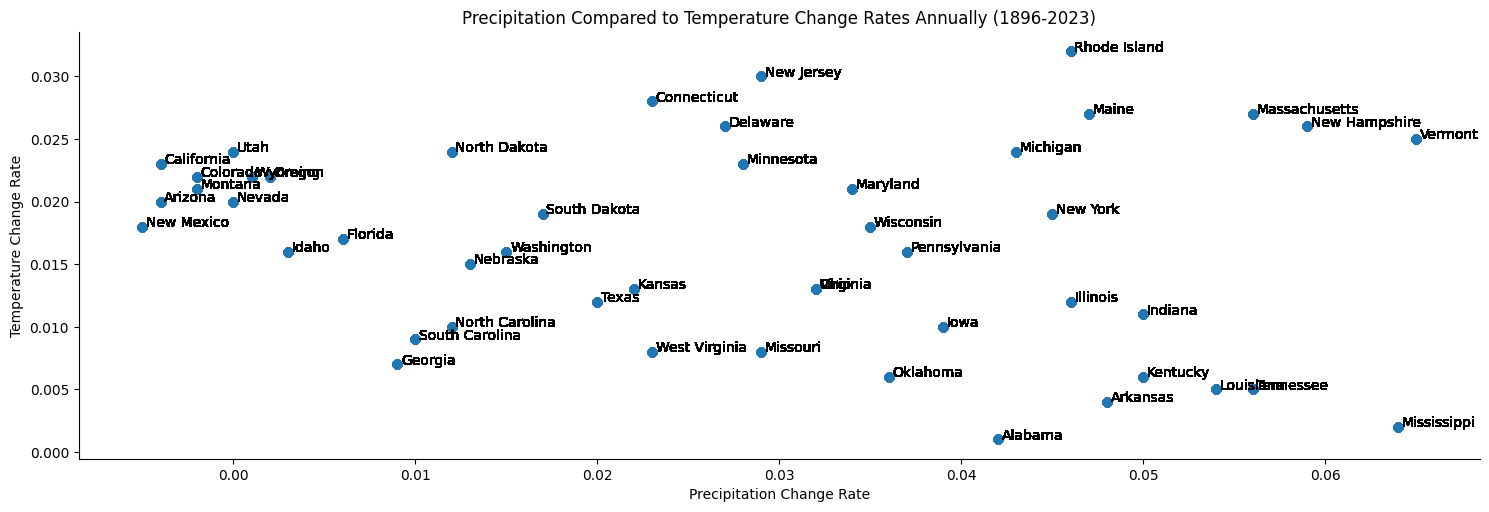

In [ ]:
# Comparing both units
import seaborn as sns
import matplotlib.pyplot as plt


ax = sns.lmplot(x = 'Precipitation Change Rate', # Horizontal axis
           y= 'Temperature Change Rate', # Vertical axis
           data=state_temp, # Data source
           fit_reg=False, # Don't fix a regression line
           aspect =3 ) # size and dimension

plt.title('Precipitation Compared to Temperature Change Rates Annually (1896-2023)')
# Set x-axis label
plt.xlabel('Precipitation Change Rate')
# Set y-axis label
plt.ylabel('Temperature Change Rate')


def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.0002, point['y'], str(point['val']))

label_point(state_temp['Precipitation Change Rate'], state_temp['Temperature Change Rate'], state_temp['State'], plt.gca())

In [ ]:
# ML
from sklearn.metrics import r2_score

def predict_year(state):
  data = compiled_data.loc[compiled_data['State'] == state]
  # get the outcome vector
  y = np.array(data['Year'].astype('int'))

  # scaled temp and precip values
  scale_temp = (data['Average Temperature']/data['Average Temperature'].std()).to_numpy()
  scale_precip = (data['Total Precipitation']/data['Total Precipitation'].std()).to_numpy()


  X_mult = np.hstack((np.array([1]*len(y)).reshape(-1,1), scale_temp.reshape(-1,1), scale_precip.reshape(-1,1)))

  b = np.matmul(np.linalg.inv(np.matmul(X_mult.T, X_mult)), np.matmul(X_mult.T, y))

  X_mult[0,1:].reshape(-1,2)

  # set up the array of predictions to fill out
  y_preds_mult = np.empty(len(X_mult))

  # loop through each observation
  for obs in range(len(X_mult)):
      # the below excludes the single row/true y belonging to obs as well as the bias column
      mult_trainX = np.concatenate((X_mult[:obs, 1:], X_mult[obs+1:, 1:]))
      mult_trainy = np.concatenate((y[:obs], y[obs+1:]))
      # then train the model
      loocv_regress = LinearRegression()
      loocv_regress.fit(mult_trainX, mult_trainy)

      # and predict the held out observation (and store it)
      y_preds_mult[obs] = loocv_regress.predict(X_mult[obs,1:].reshape(-1,2))[0]

  return y - y_preds_mult, r2_score(y, y_preds_mult), np.mean((y_preds_mult - y) ** 2)

predict_year('Florida')

(array([-27.45929761, -53.93687091, -71.89081191, -54.17474197,
        -54.5372408 , -52.80685195, -10.27526828, -51.83303827,
        -26.93167641, -31.13937029, -56.90767305, -47.45636409,
        -44.60116948, -57.07504193, -35.17488754, -15.67705217,
        -57.4460016 , -53.62364737, -25.58067673, -19.06730772,
        -31.01146496, -26.20204296,   5.47893843, -37.1910401 ,
        -45.92600234, -11.35979516, -45.64144886, -54.584086  ,
        -26.67240566, -22.79973498, -24.62471384, -14.56665617,
        -41.98553815, -20.97843804, -36.1156494 ,   2.48806815,
        -33.87649399, -32.52262275, -31.5280313 , -11.82374039,
        -12.91099902, -32.31499179,   5.98178847, -20.7545257 ,
         -6.87246379,   9.34845281,  -7.03262881,  -3.66552881,
          6.90051789, -11.1385583 , -25.10627569, -37.50263853,
          4.15148268, -47.92016049, -36.4222415 ,   8.4342854 ,
        -13.21085952,  -1.03290461, -16.20199341,   6.9534722 ,
          4.56404425,  -7.87499563,   3.

In [ ]:
# ML does not work well
from sklearn.metrics import r2_score

def predict_year(state, degree=1):
    data = compiled_data.loc[compiled_data['State'] == state]
    y = np.array(data['Year'].astype('int'))

    scale_temp = (data['Average Temperature'] / data['Average Temperature'].std()).to_numpy()
    scale_precip = (data['Total Precipitation'] / data['Total Precipitation'].std()).to_numpy()

    X = np.vstack((scale_temp, scale_precip)).T

    # Initialize array to store predictions
    y_preds = np.empty(len(X))

    # Loop through each observation for Leave-One-Out Cross-Validation (LOOCV)
    for obs in range(len(X)):
        # Exclude the observation
        trainX = np.concatenate((X[:obs], X[obs+1:]))
        trainy = np.concatenate((y[:obs], y[obs+1:]))

        # Transform features to polynomial
        poly = PolynomialFeatures(degree)
        trainX_poly = poly.fit_transform(trainX)
        testX_poly = poly.transform(X[obs].reshape(1, -1))

        # Train the model
        model = LinearRegression()
        model.fit(trainX_poly, trainy)

        # Predict the held out observation and store it
        y_preds[obs] = model.predict(testX_poly)[0]

    return np.mean((y_preds - y) ** 2), r2_score(y, y_preds)

predict_year('California',1)

(737.1998928670539, 0.4600257148016452)

# 5. Machine Learning Models

This section shows the code for the machine learning models used to predict future conditions. The project write-up explains their results and design in greater detail.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

def predict_temperature(state, degree=2):
    data = compiled_data.loc[compiled_data['State'] == state]

    X = np.array(data['Year'].astype('int')).reshape(-1, 1)
    y = np.array(data['Average Temperature'])

    # Initialize array to store predictions
    y_preds = np.empty(len(X))

    # Loop through each observation for LOOCV
    for obs in range(len(X)):
        # Exclude the observation for testing
        trainX, testX = np.delete(X, obs, axis=0), X[obs].reshape(1, -1)
        trainy = np.delete(y, obs)

        # Transform features to polynomial form
        poly = PolynomialFeatures(degree)
        trainX_poly = poly.fit_transform(trainX)
        testX_poly = poly.transform(testX)

        # Train the model
        model = LinearRegression()
        model.fit(trainX_poly, trainy)

        # Predict the held out observation and store it
        y_preds[obs] = model.predict(testX_poly)[0]

    # Calculate and return the MSE and R-squared values
    mse = mean_squared_error(y, y_preds)
    r2 = model.score(poly.transform(X), y)
    return mse, r2

In [ ]:
def predict_precipitation(state, degree=2):
    # Filter data for the selected state
    data = compiled_data.loc[compiled_data['State'] == state]

    # Define features and target
    X = np.array(data['Year'].astype('int')).reshape(-1, 1)
    y = np.array(data['Total Precipitation'])

    # Initialize array to store predictions
    y_preds = np.empty(len(X))

    # Loop through each observation for LOOCV
    for obs in range(len(X)):
        # Exclude the observation for testing
        trainX, testX = np.delete(X, obs, axis=0), X[obs].reshape(1, -1)
        trainy = np.delete(y, obs)

        # Transform features to polynomial form
        poly = PolynomialFeatures(degree)
        trainX_poly = poly.fit_transform(trainX)
        testX_poly = poly.transform(testX)

        # Train the model
        model = LinearRegression()
        model.fit(trainX_poly, trainy)

        # Predict the held out observation and store it
        y_preds[obs] = model.predict(testX_poly)[0]

    # Calculate and return the MSE and R-squared values
    mse = mean_squared_error(y, y_preds)
    r2 = model.score(poly.transform(X), y)
    return mse, r2

In [ ]:
r2_list = []
mse_list = []
us_states = compiled_data['State'].unique()

for state in us_states:
    mse, r2 = predict_temperature(state, 3)
    r2_list.append(round(r2, 2))
    mse_list.append(round(mse, 2))

df_map = pd.DataFrame({
    'State': us_states,
    'Temperature R^2': r2_list,
    'Temperature MSE': mse_list
})

df_map['Code'] = df_map['State'].map(code)

In [ ]:
average_mse = df_map['Temperature MSE'].mean()
average_r2 = df_map['Temperature R^2'].mean()

fig = px.choropleth(df_map,
                    locations='Code',
                    color='Temperature R^2',
                    color_continuous_scale='spectral_r',
                    hover_data={'Temperature R^2': True, 'Temperature MSE': True, 'Code': False},
                    hover_name='State',
                    locationmode='USA-states',
                    scope='usa')
fig.update_layout(title='R^2 Values of Temperature Predictions by State (Degree 3 Polynomial Regression)')
fig.add_scattergeo(
    locations=df_map['Code'],
    locationmode="USA-states",
    text=df_map['Temperature R^2'],
    mode='text',
    textfont=dict(
        family="helvetica",
        size=10,
        color="black"
    ))

fig.add_annotation(
    x=0.5,
    y=-0.1,
    xref='paper',
    yref='paper',
    text=f'Average R-squared: {average_r2:.2f}, Average MSE: {average_mse:.2f}',
    showarrow=False,
    font=dict(
        family="helvetica",
        size=12,
        color="black"
    ),
    align="center"
)

fig.show()


In [ ]:
r2_list = []
mse_list = []
us_states = compiled_data['State'].unique()

for state in us_states:
    mse, r2 = predict_precipitation(state, 3)
    r2_list.append(round(r2, 2))
    mse_list.append(round(mse, 2))

df_map = pd.DataFrame({
    'State': us_states,
    'Precipitation R^2': r2_list,
    'Precipitation MSE': mse_list
})

df_map['Code'] = df_map['State'].map(code)

In [ ]:
average_mse = df_map['Precipitation MSE'].mean()
average_r2 = df_map['Precipitation R^2'].mean()

fig = px.choropleth(df_map,
                    locations='Code',
                    color='Precipitation MSE',
                    color_continuous_scale='spectral_r',
                    hover_data={'Precipitation R^2': True, 'Precipitation MSE': True, 'Code': False},
                    hover_name='State',
                    locationmode='USA-states',
                    scope='usa')
fig.update_layout(title='MSE Values of Precipitation Predictions by State (Degree 3 Polynomial Regression)')
fig.add_scattergeo(
    locations=df_map['Code'],
    locationmode="USA-states",
    text=df_map['Precipitation MSE'],
    mode='text',
    textfont=dict(
        family="helvetica",
        size=10,
        color="black"
    ))

fig.add_annotation(
    x=0.5,
    y=-0.1,
    xref='paper',
    yref='paper',
    text=f'Average R-squared: {average_r2:.2f}, Average MSE: {average_mse:.2f}',
    showarrow=False,
    font=dict(
        family="helvetica",
        size=12,
        color="black"
    ),
    align="center"
)

fig.show()

In [ ]:
def predict_temperature(state, degree=1):
    data = compiled_data.loc[compiled_data['State'] == state]
    X = data[['Year', 'Total Precipitation']].to_numpy()
    y = data['Average Temperature'].to_numpy()

    # Initialize array to store predictions
    y_preds = np.empty(len(X))

    for obs in range(len(X)):
        # Exclude the observation for LOOCV
        trainX, testX = np.delete(X, obs, axis=0), X[obs].reshape(1, -1)
        trainy, testy = np.delete(y, obs), y[obs]

        # Polynomial transformation
        poly = PolynomialFeatures(degree)
        trainX_poly = poly.fit_transform(trainX)
        testX_poly = poly.transform(testX)

        # Train the model
        model = LinearRegression()
        model.fit(trainX_poly, trainy)

        # Predict and store
        y_preds[obs] = model.predict(testX_poly)[0]

    # Performance Metrics
    mse = mean_squared_error(y, y_preds)
    r2 = r2_score(y, y_preds)

    return mse, r2

In [ ]:
r2_list = []
mse_list = []
us_states = compiled_data['State'].unique()

for state in us_states:
    mse, r2 = predict_temperature(state, 3)
    r2_list.append(round(r2, 2))
    mse_list.append(round(mse, 2))

df_map = pd.DataFrame({
    'State': us_states,
    'Temperature R^2': r2_list,
    'Temperature MSE': mse_list
})

df_map['Code'] = df_map['State'].map(code)

In [ ]:
average_mse = df_map['Temperature MSE'].mean()
average_r2 = df_map['Temperature R^2'].mean()

fig = px.choropleth(df_map,
                    locations='Code',
                    color='Temperature MSE',
                    color_continuous_scale='spectral_r',
                    hover_data={'Temperature R^2': True, 'Temperature MSE': True, 'Code': False},
                    hover_name='State',
                    locationmode='USA-states',
                    scope='usa')
fig.update_layout(title='MSE Values of Temperature Predictions by State (Degree 3 Polynomial Regression)')
fig.add_scattergeo(
    locations=df_map['Code'],
    locationmode="USA-states",
    text=df_map['Temperature MSE'],
    mode='text',
    textfont=dict(
        family="helvetica",
        size=10,
        color="black"
    ))
fig.add_annotation(
    x=0.5,
    y=-0.1,
    xref='paper',
    yref='paper',
    text=f'Average R-squared: {average_r2:.2f}, Average MSE: {average_mse:.2f}',
    showarrow=False,
    font=dict(
        family="helvetica",
        size=12,
        color="black"
    ),
    align="center"
)
fig.show()
